In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
import lightgbm
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
import catboost
from bayes_opt import BayesianOptimization

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import umap

from sklearn.linear_model import LogisticRegression
from scipy import stats

c:\Users\USER\anaconda3\envs\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# data 불러오기
data = pd.read_csv('./data/train.csv')

In [5]:
data.shape

(51047, 58)

In [3]:
data.info() # 51047개의 데이터 dtypes: float64(26), int64(9), object(23)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

In [4]:
data.head(10).iloc[:, :10]
data.head(10).iloc[:, 10:20]
data.head(10).iloc[:, 20:30]
data.head(10).iloc[:, 30:40]
data.head(10).iloc[:, 40:50]
data.head(10).iloc[:, 50:] # 대략적인 데이터 구조를 확인

,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,No,0,10,No,4-Medium,Other,Other,No
4,No,1,10,No,1-Highest,Other,Professional,Yes
5,No,1,30,No,3-Good,Other,Other,Yes
6,No,1,30,No,1-Highest,Other,Self,Yes
7,No,0,30,No,1-Highest,Other,Professional,No
8,No,0,80,No,1-Highest,Other,Other,Yes
9,No,1,30,No,3-Good,Other,Professional,No


In [4]:
data.isna().sum() # 결측치 확인
data.isna().sum().sum() # 결측치 최대 3515개 인거 확인 전부 drop해도 최소 약47000개 정도 남으니까 전부 drop
#data = data.dropna().reset_index(drop=True)

3515

In [6]:
data.duplicated().sum() # 중복값 확인, 결과는 0

0

([<matplotlib.patches.Wedge at 0x29d27f8d8a0>,
 [Text(-0.6791416389841495, 0.8653130267122549, 'No'),
  Text(0.7100116287844073, -0.9046455034934476, 'Yes')],
 [Text(-0.3704408939913542, 0.47198892366122985, '71.2%'),
  Text(0.40131092061727364, -0.5113213715397746, '28.8%')])

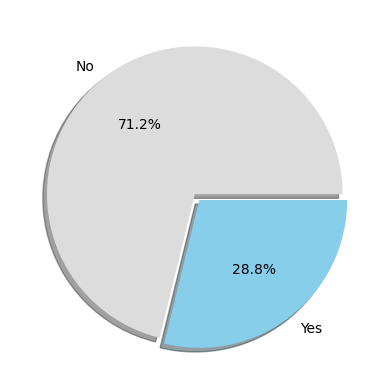

In [9]:
plt.pie(
    data.Churn.value_counts(),
    explode = [0, 0.05], # 각 조각 사이 거리
    labels = data.Churn.value_counts().index,
    autopct='%1.1f%%', # 퍼센트 표시
    colors=['#dcdcdc', '#87ceeb'],
    shadow=True
)

C:\Users\USER\AppData\Local\Temp\ipykernel_10800\1454173154.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Churn', ax=ax[1], palette=['#87ceeb', '#dcdcdc'])


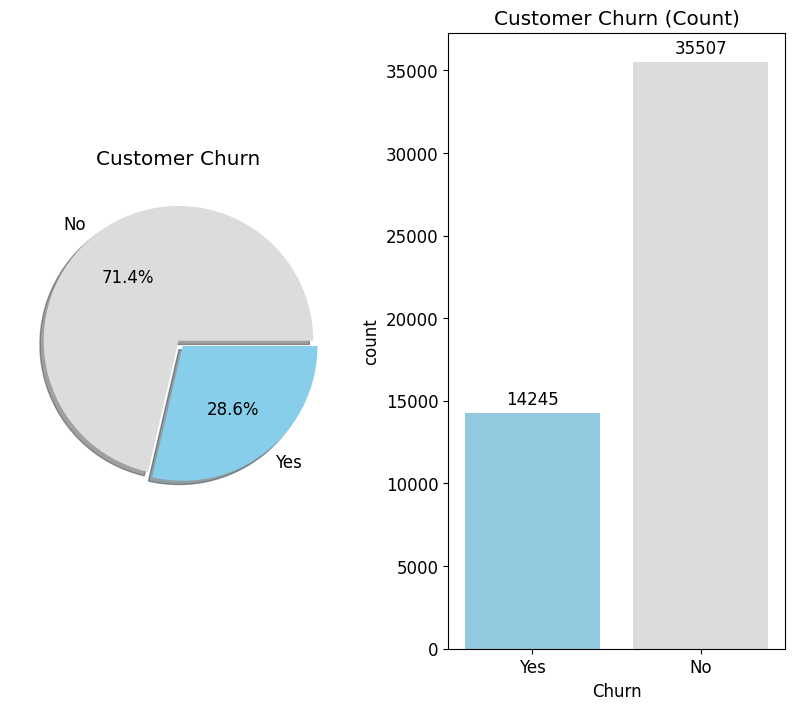

In [12]:
f, ax = plt.subplots(1, 2, figsize = (10, 8)) 
plt.subplots_adjust(wspace=0.3)

data['Churn'].value_counts().plot.pie(explode = [0, 0.05], # 각 조각 사이 거리
                                       autopct='%1.1f%%', # 퍼센트 표시
                                       ax=ax[0], # 첫번째 위치에 그리기
                                       colors=['#dcdcdc', '#87ceeb'],
                                       shadow=True) 

ax[0].set_title('Customer Churn')
ax[0].set_ylabel('') 

sns.countplot(data=data, x='Churn', ax=ax[1], palette=['#87ceeb', '#dcdcdc'])
for p in ax[1].patches: # 데이터 텍스트 표시 
    ax[1].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')    
ax[1].set_title('Customer Churn (Count)')

plt.rcParams['font.size'] = 12

plt.show()

<Axes: xlabel='CustomerID', ylabel='count'>

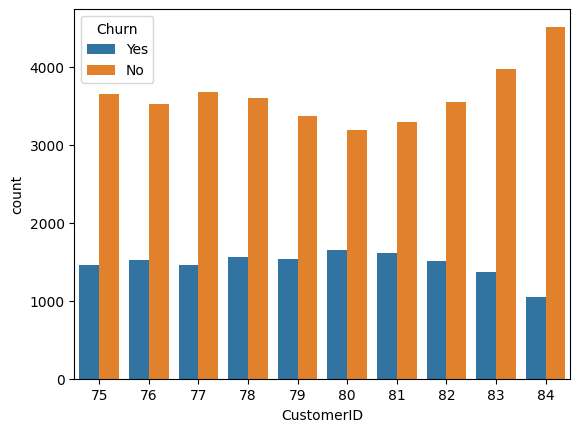

In [6]:
new_data_1 = data.filter(items=['Churn', 'CustomerID']) # CustomterID가 Index역할을 하고 있는데 혹시 범위별로 묶으면 유의미한 변수일까 확인
new_data_1.CustomerID = new_data_1.CustomerID//40000 # CustomerID 범주화 40000개씩 묶음
new_data_1

sns.countplot(
    new_data_1,
    x= 'CustomerID',
    hue= 'Churn'
)
# 범주를 묶어서 확인해 봤는데 유의미한 변화 X

<Axes: xlabel='CustomerID', ylabel='count'>

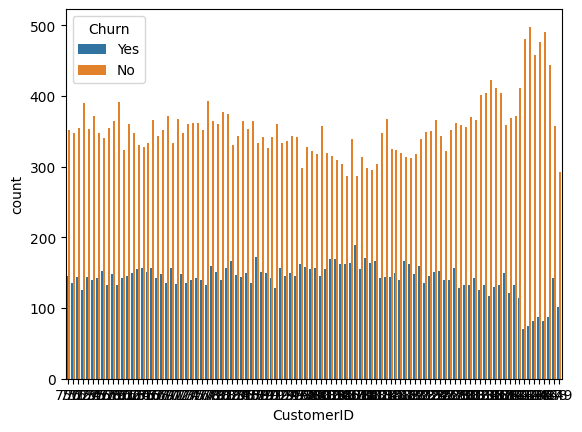

In [49]:
new_data_1 = data.filter(items=['Churn', 'CustomerID'])
new_data_1.CustomerID = new_data_1.CustomerID//4000 # 이번에는 CustomerID 4000개씩 묶음
sns.countplot(
    new_data_1,
    x= 'CustomerID',
    hue= 'Churn'
)
# 마찬가지로 의미없음

In [50]:
data = data.drop(columns=['CustomerID']).reset_index(drop=True)
data

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49747,No,0.00,76.0,30.0,0.00,0.0,0.0,0.0,0.0,5.7,...,0,4,No,0,Unknown,No,2-High,Other,Professional,No
49748,No,31.92,63.0,17.0,0.00,43.0,0.0,-38.0,-13.2,0.7,...,0,3,No,0,Unknown,No,3-Good,Other,Other,Yes
49749,No,71.99,724.0,70.0,0.00,4.0,0.9,-40.0,-2.0,14.3,...,0,7,No,0,Unknown,No,1-Highest,Other,Professional,Unknown
49750,Yes,117.49,384.0,30.0,0.00,250.0,0.0,0.0,0.0,4.0,...,0,2,No,0,30,No,5-Low,Other,Professional,Yes


<Axes: >

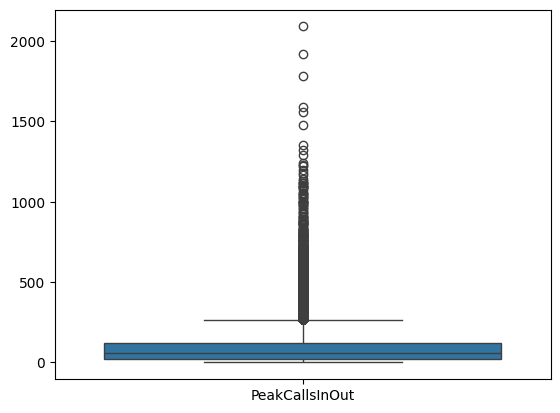

In [51]:
# 숫자 데이터들 이상치 확인 노가다 .iloc[0] 0을 하나씩 늘려가면서 찍어봄
# 사분위 수 범위에서 크게 벗어나는 애들 제거거
sns.boxplot(
    data.loc[:, (data.dtypes != object)].iloc[:, [16]],
)

In [52]:
columns_to_zscore = ['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge',
       'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls',
       'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls',
       'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls',
       'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
       'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls',
       'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs',
       'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2',
       'RetentionCalls', 'RetentionOffersAccepted',
       'ReferralsMadeBySubscriber', 'IncomeGroup',
       'AdjustmentsToCreditRating']
z_scores = stats.zscore(data[columns_to_zscore])
outliers_mask = (abs(z_scores) > 3).any(axis=1)
data = data[~outliers_mask]

<Axes: >

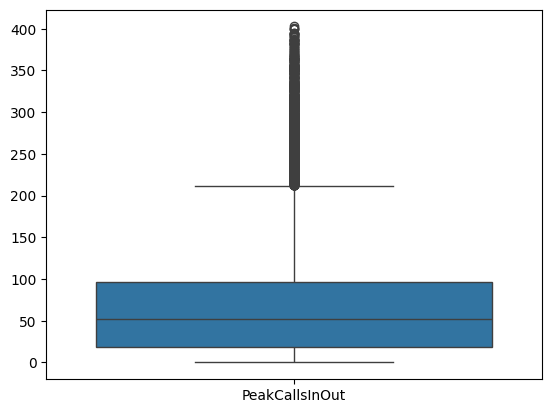

In [53]:
# 만족스럽게 제거 됐는지 확인

sns.boxplot(
    data.loc[:, (data.dtypes != object)].iloc[:, [16]],
)

In [54]:
data.loc[:, (data.sum() == 0)].value_counts() # 이상치 제거 후 0으로 통일된 값들 확인

RetentionCalls  RetentionOffersAccepted  ReferralsMadeBySubscriber
0               0                        0                            37723
Name: count, dtype: int64

In [55]:
data = data.drop(columns=['RetentionCalls', 'RetentionOffersAccepted', 'ReferralsMadeBySubscriber']) # drop

<Axes: xlabel='MonthlyRevenue', ylabel='Density'>

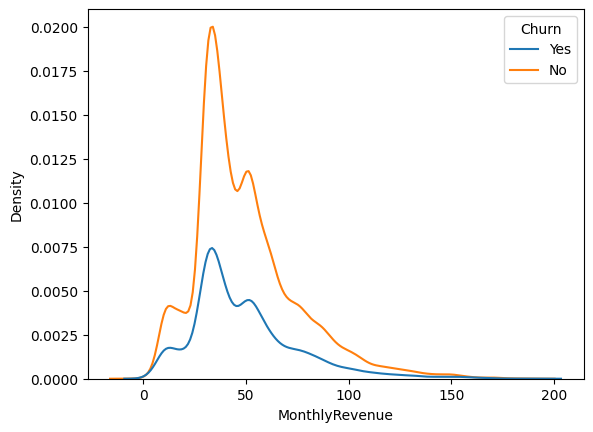

In [56]:
# 수치형데이터 확률밀도함수 확인 (데이터 분포)

sns.kdeplot(
    data,
    x= data.loc[:, (data.dtypes != object)].columns[0],
    hue='Churn'
)

<Axes: xlabel='NotNewCellphoneUser', ylabel='count'>

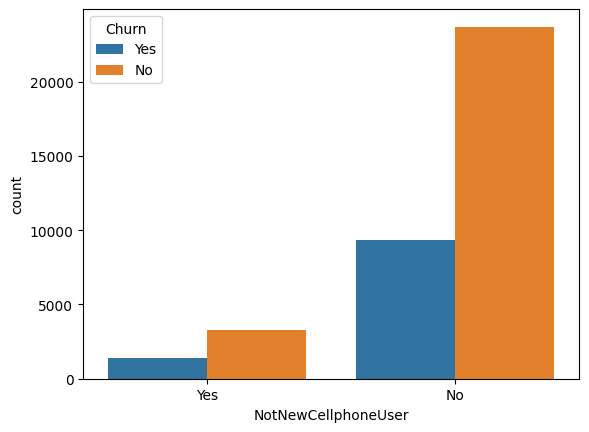

In [57]:
# 범주형데이터 데이터 분포 확인

sns.countplot(
    data,
    x=data.loc[:, (data.dtypes == object)].columns[15],
    hue='Churn'             
)

In [58]:
# object형 숫자형으로 바꿔주기
label_encoders = {}
for column in data.loc[:, (data.dtypes == object)].columns:
    label_encoder = LabelEncoder()
    data.loc[:, column] = label_encoder.fit_transform(data[column])

    label_encoders.update({column: label_encoder})

data = data.astype(dict(zip(np.extract(data.dtypes == object , data.columns), ['float']*23)))

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37723 entries, 228 to 49750
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      37723 non-null  float64
 1   MonthlyRevenue             37723 non-null  float64
 2   MonthlyMinutes             37723 non-null  float64
 3   TotalRecurringCharge       37723 non-null  float64
 4   DirectorAssistedCalls      37723 non-null  float64
 5   OverageMinutes             37723 non-null  float64
 6   RoamingCalls               37723 non-null  float64
 7   PercChangeMinutes          37723 non-null  float64
 8   PercChangeRevenues         37723 non-null  float64
 9   DroppedCalls               37723 non-null  float64
 10  BlockedCalls               37723 non-null  float64
 11  UnansweredCalls            37723 non-null  float64
 12  CustomerCareCalls          37723 non-null  float64
 13  ThreewayCalls              37723 non-null  float6

In [60]:
# 인덱스 초기화
data = data.reset_index(drop=True)
data

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,NotNewCellphoneUser,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,1.0,64.80,479.0,50.0,0.00,139.0,0.0,-337.0,-13.3,0.7,...,1.0,3,0.0,0,8.0,0.0,0.0,2.0,4.0,2.0
1,0.0,61.02,134.0,70.0,0.50,0.0,0.0,-12.0,0.0,1.7,...,1.0,0,0.0,0,8.0,0.0,0.0,0.0,3.0,1.0
2,1.0,70.71,369.0,50.0,7.18,0.0,3.8,-7.0,-5.3,4.0,...,0.0,0,0.0,0,8.0,0.0,0.0,0.0,3.0,1.0
3,1.0,61.62,674.0,55.0,2.97,30.0,0.0,169.0,10.3,2.7,...,0.0,6,1.0,1,8.0,0.0,0.0,2.0,3.0,2.0
4,1.0,72.65,493.0,50.0,1.24,7.0,0.7,220.0,3.1,2.3,...,1.0,3,0.0,0,3.0,0.0,0.0,2.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37718,1.0,38.34,320.0,30.0,0.99,21.0,0.0,-66.0,-8.3,12.3,...,0.0,6,0.0,0,15.0,0.0,0.0,0.0,4.0,0.0
37719,0.0,0.00,76.0,30.0,0.00,0.0,0.0,0.0,0.0,5.7,...,0.0,4,0.0,0,15.0,0.0,1.0,0.0,4.0,0.0
37720,0.0,31.92,63.0,17.0,0.00,43.0,0.0,-38.0,-13.2,0.7,...,0.0,3,0.0,0,15.0,0.0,2.0,0.0,3.0,2.0
37721,0.0,71.99,724.0,70.0,0.00,4.0,0.9,-40.0,-2.0,14.3,...,0.0,7,0.0,0,15.0,0.0,0.0,0.0,4.0,1.0


In [61]:
# data내보내기

data.to_csv('./data/preprocessing_train.csv', index= False)

In [62]:
data.shape

(37723, 54)

In [63]:
pd.read_csv('./data/preprocessing_train.csv')

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,NotNewCellphoneUser,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,1.0,64.80,479.0,50.0,0.00,139.0,0.0,-337.0,-13.3,0.7,...,1.0,3,0.0,0,8.0,0.0,0.0,2.0,4.0,2.0
1,0.0,61.02,134.0,70.0,0.50,0.0,0.0,-12.0,0.0,1.7,...,1.0,0,0.0,0,8.0,0.0,0.0,0.0,3.0,1.0
2,1.0,70.71,369.0,50.0,7.18,0.0,3.8,-7.0,-5.3,4.0,...,0.0,0,0.0,0,8.0,0.0,0.0,0.0,3.0,1.0
3,1.0,61.62,674.0,55.0,2.97,30.0,0.0,169.0,10.3,2.7,...,0.0,6,1.0,1,8.0,0.0,0.0,2.0,3.0,2.0
4,1.0,72.65,493.0,50.0,1.24,7.0,0.7,220.0,3.1,2.3,...,1.0,3,0.0,0,3.0,0.0,0.0,2.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37718,1.0,38.34,320.0,30.0,0.99,21.0,0.0,-66.0,-8.3,12.3,...,0.0,6,0.0,0,15.0,0.0,0.0,0.0,4.0,0.0
37719,0.0,0.00,76.0,30.0,0.00,0.0,0.0,0.0,0.0,5.7,...,0.0,4,0.0,0,15.0,0.0,1.0,0.0,4.0,0.0
37720,0.0,31.92,63.0,17.0,0.00,43.0,0.0,-38.0,-13.2,0.7,...,0.0,3,0.0,0,15.0,0.0,2.0,0.0,3.0,2.0
37721,0.0,71.99,724.0,70.0,0.00,4.0,0.9,-40.0,-2.0,14.3,...,0.0,7,0.0,0,15.0,0.0,0.0,0.0,4.0,1.0
